Utility Functions

In [1]:
import torch
import torch.nn.functional as func
import PIL.Image
import random
import json
import pathlib
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

def load_image_as_tensor(_path, _size, _resample=PIL.Image.Resampling.BICUBIC):
    img = PIL.Image.open(_path)
    img = img.resize((_size, _size), _resample)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]
    return torch.from_numpy(img)[None, ...]

def show_tensor_as_image(_img):
    img = to_rgb(_img).squeeze()
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
def to_rgb(_x, _alpha='BLACK'):
    rgb, a = _x[:, :, :, :3], _x[:, :, :, 3:4]
    if _alpha == 'BLACK':
        return rgb
    elif _alpha == 'WHITE':
        return 1.-a + rgb

def circle_mask(_size, _radius, _pos):
    Y, X = np.ogrid[:_size, :_size]
    dist_from_center = np.sqrt((X - _pos[0])**2 + (Y-_pos[1])**2)
    mask = dist_from_center >= _radius
    return mask

def show_batch(batch_size, before, after, dpi=256):
    fig = plt.figure(figsize=(batch_size, 2), dpi=dpi)
    axarr = fig.subplots(nrows=2, ncols=batch_size)
    gspec = gridspec.GridSpec(2, batch_size)
    gspec.update(wspace=0.1, hspace=0) # set the spacing between axes.
    plt.clf()
    
    for i in range(batch_size):
        img_i = before[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = to_rgb(img_i)
        axarr[0, i] = plt.subplot(gspec[i])
        axarr[0, i].set_xticks([])
        axarr[0, i].set_yticks([])
        axarr[0, i].imshow(img_rgb, aspect='equal')
        axarr[0, i].set_title(str(i), fontsize=8)
        
    for i in range(batch_size):
        img_i = after[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = to_rgb(img_i)
        axarr[1, i] = plt.subplot(gspec[i+batch_size])
        axarr[1, i].set_xticks([])
        axarr[1, i].set_yticks([])
        axarr[1, i].imshow(img_rgb, aspect='equal')
        
    plt.show()

# * set device
_DEVICE_ = 'cuda' if torch.cuda.is_available() else 'cpu'
print ('cuda available? ', torch.cuda.is_available())
print ('device: ', _DEVICE_)

cuda available?  True
device:  cuda


Load Pre-Made Seed

seed_img.shape:  torch.Size([1, 64, 64, 4])


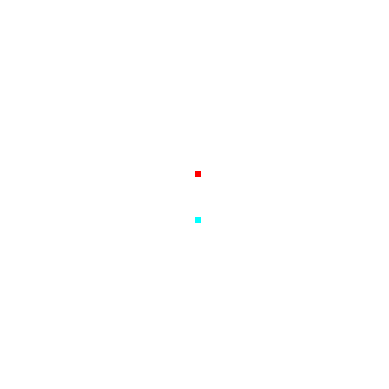

In [2]:
_SEED_FILE_ = '_2_seeds_64.png'
_SIZE_ = 64

seed_img = load_image_as_tensor('..\\_seeds\\'+_SEED_FILE_,  _SIZE_)
print ('seed_img.shape: ', seed_img.shape)
show_tensor_as_image(to_rgb(seed_img, 'WHITE'))

Target Image to Train Model
- NOTE: seed _SIZE_ should equal _TARGET-SIZE_ + (2 * _PAD_)

target.shape:  torch.Size([1, 64, 64, 4])


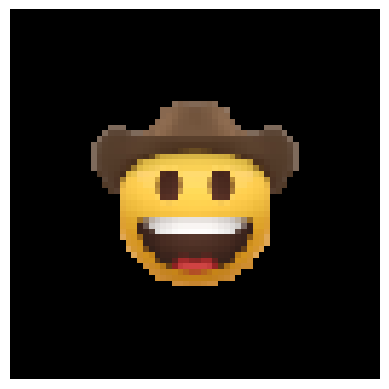

In [3]:
_TARGET_FILE_ = 'cowboy.png'
_TARGET_SIZE_ = 40
_PAD_ = 12

target_img = load_image_as_tensor('..\\_images\\'+_TARGET_FILE_, _TARGET_SIZE_)
target_img = target_img.permute(0, 3, 1, 2)
target_img = torch.nn.functional.pad(target_img, (_PAD_, _PAD_, _PAD_, _PAD_), 'constant', 0)
target_img = target_img.permute(0, 2, 3, 1)
print ('target.shape: ', target_img.shape)
show_tensor_as_image(target_img)

Perceptions:
- LAPLACIAN: isotropic nca model
- SOBEL_MAG: isotrpic nca variant which adds upon the 'laplacian' model by making use of the magnitude of the two directional sobel filters
- STEERABLE: angle-based steerable nca
- GRADIENT: gradient-based steerable nca

In [8]:
# kernels
ID_KERN = torch.tensor([
    [0., 0., 0.], 
    [0., 1., 0.], 
    [0., 0., 0.]])
SOBEL_KERN = torch.tensor([
    [-1., 0., 1.], 
    [-2., 1., 2.], 
    [-1., 0., 1.]])
LAP_KERN = torch.tensor([
    [1.,   2., 1.], 
    [2., -12., 2.], 
    [1.,   2., 1.]])

def per_channel_conv(_x, _filters):
    batch_size, height, width, channels = _x.shape
    print ('per-channel conv start')
    print ('batch_size: ', batch_size)
    print ('height: ', height)
    print ('width: ', width)
    print ('channels: ', channels)
    print ('_x.shape: ', _x.shape)
    # * reshape x to make per-channel convolution possible + pad 1 on each side
    y = _x.permute(0, 3, 1, 2)
    print ('permute y.shape: ', y.shape)
    y = y.reshape(batch_size*channels, 1, height, width)
    print ('reshaped y.shape: ', y.shape)
    y = func.pad(y, (1, 1, 1, 1), 'circular')
    print ('padded y.shape: ', y.shape)
    # * perform per-channel convolutions
    _filters = _filters.to(_DEVICE_)
    y = y.to(_DEVICE_)
    y = func.conv2d(y, _filters[:, None])
    print ('convolved y.shape: ', y.shape)
    y = y.reshape(batch_size, -1, height, width)
    print ('reshaped y.shape: ', y.shape)
    y = y.permute(0, 2, 3, 1)
    print ('permute y.shape: ', y.shape)
    return y

def laplacian_perception(_x):
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    y = torch.cat([_x, lap_conv], 1)
    return y

def sobel_mag_perception(_x):
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    sobel_conv = per_channel_conv(_x, torch.stack([SOBEL_KERN, SOBEL_KERN.T]))
    gx, gy = sobel_conv[:, ::2], sobel_conv[:, 1::2]
    y = torch.cat([_x, lap_conv, (gx*gx+gy*gy+1e-8).sqrt()], 1)
    return y

def steerable_perception(_x):
    # * separate states and angle channels
    states, angle = _x[:, :-1], _x[:, -1:]
    filters = torch.stack([SOBEL_KERN, SOBEL_KERN.T])
    grad = per_channel_conv(states, filters)
    gx, gy = grad[:, ::2], grad[:, 1::2]
    # * get cos and sin of angle channel and apply rotation to gx, gy
    c, s = angle.cos(), angle.sin()
    rot_grad = torch.cat([gx*c+gy*s, gy*c-gx*s], 1)
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    y = torch.cat([states, rot_grad, lap_conv], 1)

def gradient_perception(_x):
    filters = torch.stack([SOBEL_KERN, SOBEL_KERN.T])
    grad = per_channel_conv(_x, filters)
    grad, dir = grad[:, :-2], grad[:, -2:]
    dir = dir / dir.norm(dim=1, keepdim=True).clip(1.0)
    gx, gy = grad[:, ::2], grad[:, 1::2]
    c, s = dir[:, :1], dir[:, 1::2]
    rot_grad = torch.cat([gx*c+gy*s, gy*c-gx*s], 1)
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    y = torch.cat([_x, rot_grad, lap_conv], 1)
    return y
    
perception = {
    'LAPLACIAN': laplacian_perception,
    'SOBEL_MAG': sobel_mag_perception,
    'STEERABLE': steerable_perception,
    'GRADIENT': gradient_perception    
}

def get_alive_mask(_x):
    is_alive = (_x[:, :, :, 3:4] > 0.1).to(torch.float32)
    y = per_channel_conv(is_alive, LAP_KERN[None, :]) > 0.5
    return y

Neural Cellular Automata Model

In [5]:
_CHANNELS_ = 16
_MODEL_TYPE_ = 'LAPLACIAN'  #['LAPLACIAN', 'SOBEL_MAG', 'STEERABLE', 'GRADIENT']
_STOCHASTIC_UPDATE_RATE_ = 0.5
_ANGLE_CHANNEL_ = 1 if _MODEL_TYPE_ == 'STEERABLE' else 0
_SCALAR_CHANNEL_ = _CHANNELS_ - _ANGLE_CHANNEL_

class NCA(torch.nn.Module):
    def __init__(self, _channels=_CHANNELS_, _hidden=128):
        super().__init__()
        self.channels = _channels
        
        # * determine number of perceived channels
        perception_channels = perception[_MODEL_TYPE_](torch.zeros([1, _SIZE_, _SIZE_, _channels]).to(_DEVICE_)).shape[3]
        
        # * determine hidden channels (equalize the parameter count btwn model types)
        hidden_channels = 8*1024 // (perception_channels+_channels)
        hidden_channels = (_hidden+31) // 32*32
        
        # * model layers
        self.conv1 = torch.nn.Conv2d(perception_channels, hidden_channels, 1)
        self.conv2 = torch.nn.Conv2d(hidden_channels, _channels, 1, bias=False)
        self.conv2.weight.data.zero_()
        
    def forward(self, _x):
        print ('forward start')
        print ('init _x.shape: ', _x.shape)
        # * get alive mask
        alive_mask = get_alive_mask(_x)
        
        # * perception step
        _x = _x.to(_DEVICE_)
        print ('before perception _x.shape: ', _x.shape)
        y = perception[_MODEL_TYPE_](_x)
        print ('after perception y.shape: ', y.shape)
        
        # * update step
        y = y.permute(0, 3, 1, 2)
        y = self.conv2(torch.relu(self.conv1(y)))
        y = y.permute(0, 2, 3, 1)
        
        # * create stochastic update mask
        batch_size, height, width, channels = _x.shape
        stochastic_update_mask = (torch.rand(batch_size, height, width, 1) + _STOCHASTIC_UPDATE_RATE_).floor()
        
        # * perform update
        x = _x + y * stochastic_update_mask
        if _SCALAR_CHANNEL_ == _CHANNELS_:
            x = x * alive_mask
        else:
            states = x[:, :_SCALAR_CHANNEL_] * alive_mask
            angle = x[:, _SCALAR_CHANNEL_:] % (2.0*torch.pi)
            x = torch.cat([states, angle], 1)
        return x

Loss Functions:
- PIXEL-WISE: L2-norm loss
- INVARIANT: rotation-invariant loss

In [6]:
_LOSS_FUNC_ = 'PIXEL_WISE' #['PIXEL_WISE', 'INVARIANT']
_LOWER_LR_ = 1e-5
_UPPER_LR_ = 1e-3

def pixel_wise_loss_func(_x, _target, _scale=1e3):
    return _scale * ((_target[:, :, :, :4, ...] - _x[:, :, :, :4, ...]) ** 2).mean(dim=[1, 2, 3])

def invariant_loss_func(_x):
    raise NotImplementedError

loss_func = {
    'PIXEL_WISE': pixel_wise_loss_func,
    'INVARIANT': invariant_loss_func
}

Training Loop

In [9]:
_NAME_ = 'cowboy'
_EPOCHS_ = 15000
_POOL_SIZE_ = 256
_BATCH_SIZE_ = 8
_NUM_DAMG_ = 4

_DAMG_RATE_ = 5
_INFO_RATE_ = 20
_SAVE_RATE_ = 500

# * save model method
def save_model(_dir, _model, _name):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    torch.save(_model.state_dict(), _dir + '\\' + _name + '.pt')
    
    # * save model parameters
    dict = {
        '_SEED_FILE_': _SEED_FILE_,
        '_SIZE_': _SIZE_,
        
        '_TARGET_FILE_': _TARGET_FILE_,
        '_TARGET_SIZE_': _TARGET_SIZE_,
        '_PAD_': _PAD_,
        
        '_CHANNELS_': _CHANNELS_,
        '_MODEL_TYPE_': _MODEL_TYPE_,
        '_STOCHASTIC_UPDATE_RATE_': _STOCHASTIC_UPDATE_RATE_,
        '_ANGLE_CHANNEL_': _ANGLE_CHANNEL_,
        '_SCALAR_CHANNEL_': _SCALAR_CHANNEL_,
        
        '_LOSS_FUNC_': _LOSS_FUNC_,
        '_LOWER_LR_': _LOWER_LR_,
        '_UPPER_LR_': _UPPER_LR_,
        
        '_NAME_': _NAME_,
        '_EPOCHS_': _EPOCHS_,
        '_POOL_SIZE_': _POOL_SIZE_,
        '_BATCH_SIZE_': _BATCH_SIZE_,
        '_NUM_DAMG_': _NUM_DAMG_,
        
        '_DAMG_RATE_': _DAMG_RATE_,
        '_INFO_RATE_': _INFO_RATE_,
        '_SAVE_RATE_': _SAVE_RATE_,
        '_DEVICE_': _DEVICE_,
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '\\' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
        print ('model saved!')

# * create model
model = NCA().to(_DEVICE_)
opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)

# * create seed pool
target = torch.cat([target_img, torch.zeros([1, _SIZE_, _SIZE_, _CHANNELS_-4])], 3).to(_DEVICE_)
seed = torch.cat([seed_img, torch.zeros([1, _SIZE_, _SIZE_, _CHANNELS_-4])], 3).to(_DEVICE_)
pool = seed.clone().repeat(_POOL_SIZE_, 1, 1, 1)

loss_log = []
progress = 0

# * begin training 
for _ in range(_EPOCHS_+1):
    with torch.no_grad():
        # * sample batch from pool
        i = len(loss_log)
        batch_idxs = np.random.choice(_POOL_SIZE_, _BATCH_SIZE_, replace=False)
        x = pool[batch_idxs]
        
        # * re-order batch based on loss
        loss_ranks = torch.argsort(loss_func[_LOSS_FUNC_](x, target), descending=True)
        x = x[loss_ranks]
        
        # * re-add seed into batch
        seed_swap_rate = 1 if i < 4000 else 5
        if i % seed_swap_rate == 0:
            x[:1] = seed
            
        # * damage lowest loss in batch
        if i > 4000 and i % _DAMG_RATE_ == 0:
            radius = random.uniform(_SIZE_*0.1, _SIZE_*0.3)
            u = random.uniform(0, 1) * _SIZE_
            v = random.uniform(0, 1) * _SIZE_
            mask = circle_mask(_SIZE_, radius, [u, v])
            x[-_NUM_DAMG_:] *= torch.tensor(mask).to(_DEVICE_)
            
    # * calculate loss
    overflow_loss = 0.0
    diff_loss = 0.0
    target_loss = 0.0
    num_steps = np.random.randint(64, 96)
    
    # visualize batch
    if i % _INFO_RATE_ == 0:
        before = x.detach().cpu()
    
    # * forward pass
    for _ in range(num_steps):
        prev_x = x
        x = model(x)
        diff_loss += (x - prev_x).abs().mean()
        overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :, :, :_SCALAR_CHANNEL_].square().sum()
        
    target_loss += loss_func[_LOSS_FUNC_](x, target)
    diff_loss *= 10.0
    loss = target_loss + overflow_loss + diff_loss
    
    with torch.no_grad():
        loss.backward()
        for p in model.parameters():
            p.grad /= (p.grad.norm()+1e-8)
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        pool[batch_idxs] = x
        loss_log.append(loss.item())
        
        # * print out info
        if i % _INFO_RATE_ == 0:
            # * show loss plot
            clear_output(True)
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.show()
            
            # * show batch
            after = x.detach().cpu()
            show_batch(_BATCH_SIZE_, before, after)
            
            # * print info
            print('\rstep:', i, '\tloss:', loss.item(), '\tlr:', lr_sched.get_lr()[0], end='')
            
        # * save checkpoint
        if i % _SAVE_RATE_ == 0:
            save_model('checkpoints', model, _NAME_+'_cp'+str(i))
            
# * save final model
save_model('models', model, _NAME_)

per-channel conv start
batch_size:  1
height:  64
width:  64
channels:  16
_x.shape:  torch.Size([1, 64, 64, 16])
permute y.shape:  torch.Size([1, 16, 64, 64])
reshaped y.shape:  torch.Size([16, 1, 64, 64])
padded y.shape:  torch.Size([16, 1, 66, 66])
convolved y.shape:  torch.Size([16, 1, 64, 64])
reshaped y.shape:  torch.Size([1, 16, 64, 64])
permute y.shape:  torch.Size([1, 64, 64, 16])
forward start
init _x.shape:  torch.Size([8, 64, 64, 16])
per-channel conv start
batch_size:  8
height:  64
width:  64
channels:  1
_x.shape:  torch.Size([8, 64, 64, 1])
permute y.shape:  torch.Size([8, 1, 64, 64])
reshaped y.shape:  torch.Size([8, 1, 64, 64])
padded y.shape:  torch.Size([8, 1, 66, 66])
convolved y.shape:  torch.Size([8, 1, 64, 64])
reshaped y.shape:  torch.Size([8, 1, 64, 64])
permute y.shape:  torch.Size([8, 64, 64, 1])
before perception _x.shape:  torch.Size([8, 64, 64, 16])
per-channel conv start
batch_size:  8
height:  64
width:  64
channels:  16
_x.shape:  torch.Size([8, 64, 64

RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 1